In [1]:
cd ..

/home/dmitriishubin/Desktop/Projects/mask


In [3]:
from efficientnet_pytorch import EfficientNet as effnet

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch
import numpy as np
import cv2
import json
import os
import pandas as pd

from landmark_detector import LandmarkDetector


# Settings

In [16]:
def exract_face_features(left_eye, right_eye,forehead,nose,center):

    """
    features:

    length(left_eye,fore)/length(right_eye,fore)

    angles between  eyes + forehead


    """
    
    features = {}

    a = _compute_distance_between_points(left_eye,
                                         forehead
                                         )
    b = _compute_distance_between_points(right_eye,
                                         forehead
                                         )
    c = _compute_distance_between_points(right_eye,
                                         left_eye
                                         )
    
    d = _compute_distance_between_points(forehead,
                                         center
                                         )
    
    e = _compute_distance_between_points(center,
                                         nose
                                         )
    

    features['upper_sides_proportion'] = a / b
    features['vertical_sides_proportion'] = d / c
    features['alpha'] = np.degrees(np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c)))
    features['beta'] = np.degrees(np.arccos((a ** 2 + c ** 2 - b ** 2) / (2 * a * c)))
    features['gamma'] =np.degrees(np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b)))

    return features
    
def _compute_distance_between_points( x, y):
    return np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1])**2)

In [17]:
INPUT_PATH = './data/raw/'
OUT_PATH = './data/processed/'

In [18]:

config = {
'num_faces': 1
}
landmark_detector = LandmarkDetector(config)

In [19]:
images = []
for path, subdirs, files in os.walk(INPUT_PATH):
    for name in files:
        if name.find('.png') !=-1:
            images.append(path+'/'+name)
            
images.sort()

# Extract features

In [20]:
features = []
people = []
poses = []

for image in tqdm(images):
    people.append(image.split('/')[4])
    
    pose = pd.read_csv(image[:-7]+'pose.txt',sep=' ',header=None)
    pose = pose.values[:-1,:-1]
    pose = {
    
    'theta_x' : np.degrees(np.arctan2(pose[2,1],pose[2,2])),
    'theta_y' : np.degrees(np.arctan2(-pose[2,0],np.sqrt(pose[2,1]**2+pose[2,2]**2))),
    'theta_z' : np.degrees(np.arctan2(pose[1,0],pose[0,0]))
    
    }
    poses.append(pose)
    
    image = cv2.imread(image)
    
    
    
    landmarks = landmark_detector.run(image)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if landmarks is not None:
    
        features.append(exract_face_features(left_eye=landmarks['left_eye'], 
                                             right_eye=landmarks['right_eye'],
                                             forehead=landmarks['forehead'],
                                            nose=landmarks['nose'],
                                            center=landmarks['center']))
    else:
        features.append({
            'upper_sides_proportion': None,
            'vertical_sides_proportion': None,
            'alpha': None,
            'beta':None,
            'gamma': None
        }
        )
        
poses = pd.DataFrame(poses)
people = pd.DataFrame(people)
people.columns = ['person_id']
features = pd.DataFrame(features)

df = pd.concat([features,people,poses],axis=1) 

100%|███████████████████████████████████████| 3430/3430 [00:50<00:00, 67.62it/s]


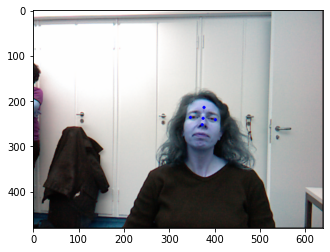

In [21]:
image = cv2.circle(image, landmarks['right_eye'], radius=2, color=(0, 0, 255), thickness=2)
image = cv2.circle(image, landmarks['left_eye'], radius=2, color=(0, 0, 255), thickness=2)
image = cv2.circle(image, landmarks['nose'], radius=2, color=(0, 0, 255), thickness=2)
image = cv2.circle(image, landmarks['forehead'], radius=2, color=(0, 0, 255), thickness=2)
image = cv2.circle(image, landmarks['center'], radius=2, color=(0, 0, 255), thickness=2)
plt.imshow(image)

In [22]:
df.head(5)

,upper_sides_proportion,vertical_sides_proportion,alpha,beta,gamma,person_id,theta_x,theta_y,theta_z
0,0.990156,0.414859,40.109598,40.591160,99.299242,01,-7.705271,3.053093,-1.991137
1,0.975714,0.452508,41.561740,42.838921,95.599339,01,-7.792844,3.595073,-2.435243
2,0.975714,0.452508,41.561740,42.838921,95.599339,01,-7.578725,3.379035,-2.408475
3,0.978068,0.471363,42.762374,43.962223,93.275403,01,-7.591798,3.515111,-2.377601
4,0.978068,0.471363,42.762374,43.962223,93.275403,01,-7.863294,3.113472,-2.569418


In [23]:
df.to_csv(OUT_PATH+'data.csv',index=False)